# 🧠 CNN/CRNN 모델 학습

이 노트북에서는 차량 사운드 분류 모델을 학습합니다.

**주요 기능:**
- 원본 + 증강 데이터 함께 사용
- SpecAugment 실시간 적용
- CNN 및 CRNN 모델 학습 및 비교
- 학습 결과 시각화


In [1]:
# ============================================================
# 필수 라이브러리 임포트 (Step 1: 기본 라이브러리)
# ============================================================

import os
import sys
sys.path.insert(0, '..')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm import tqdm
from collections import Counter
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

# 시각화 설정
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

print("✅ 기본 라이브러리 로드 완료!")


✅ 기본 라이브러리 로드 완료!


In [2]:
# ============================================================
# Step 2: PyTorch 임포트
# ============================================================

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import librosa

# 디바이스 설정
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"✅ PyTorch 로드 완료!")
print(f"🖥️ Device: {device}")
if torch.cuda.is_available():
    print(f"   GPU: {torch.cuda.get_device_name(0)}")
else:
    print("   ⚠️ GPU 없음 - CPU로 학습합니다 (느릴 수 있음)")


✅ PyTorch 로드 완료!
🖥️ Device: cpu
   ⚠️ GPU 없음 - CPU로 학습합니다 (느릴 수 있음)


In [3]:
# ============================================================
# Step 3: 프로젝트 모듈 임포트 (직접 임포트로 빠르게)
# ============================================================

# 모델 (직접 파일에서 임포트)
from app.ml.models.cnn import SoundClassifierCNN
from app.ml.models.crnn import SoundClassifierCRNN

# 피처 추출
from app.ml.features.extractor import AudioFeatureExtractor, AudioConfig
from app.ml.features.augmentation import AudioAugmentor, AugmentationConfig

# 학습
from app.ml.training.trainer import Trainer, create_optimizer, create_scheduler

print("✅ 프로젝트 모듈 로드 완료!")


✅ 프로젝트 모듈 로드 완료!


## 1. 데이터셋 클래스 정의

SpecAugment를 실시간으로 적용하는 커스텀 데이터셋을 정의합니다.


In [ ]:
# ============================================================
# 커스텀 데이터셋 클래스 (SpecAugment 실시간 적용)
# ============================================================

from typing import Optional

class SoundDataset(Dataset):
    """
    차량 사운드 데이터셋
    
    Features:
    - 원본 + 증강 데이터 함께 로드
    - SpecAugment 실시간 적용 (학습 시에만)
    - Mel Spectrogram 기반 피처 추출
    """
    
    def __init__(
        self,
        file_paths: list,
        labels: list,
        feature_extractor: AudioFeatureExtractor,
        augmentor: Optional[AudioAugmentor] = None,
        apply_spec_augment: bool = False,  # SpecAugment 적용 여부
        is_training: bool = True
    ):
        """
        Parameters:
        -----------
        file_paths : list - 오디오 파일 경로 리스트
        labels : list - 레이블 리스트
        feature_extractor : AudioFeatureExtractor - 피처 추출기
        augmentor : AudioAugmentor - 증강기 (SpecAugment용)
        apply_spec_augment : bool - SpecAugment 적용 여부
        is_training : bool - 학습 모드 여부
        """
        self.file_paths = file_paths
        self.labels = labels
        self.feature_extractor = feature_extractor
        self.augmentor = augmentor
        self.apply_spec_augment = apply_spec_augment
        self.is_training = is_training
        
    def __len__(self):
        return len(self.file_paths)
    
    def __getitem__(self, idx):
        file_path = self.file_paths[idx]
        label = self.labels[idx]
        
        # CNN용 피처 추출 (Mel Spectrogram)
        features = self.feature_extractor.extract_for_cnn(str(file_path))
        
        # SpecAugment 적용 (학습 시에만)
        if self.is_training and self.apply_spec_augment and self.augmentor is not None:
            # features shape: (1, n_mels, time_frames)
            features_2d = features[0]  # (n_mels, time_frames)
            features_2d = self.augmentor.spec_augment(
                features_2d,
                num_freq_masks=2,
                num_time_masks=2,
                freq_mask_param=15,
                time_mask_param=35
            )
            features = features_2d[np.newaxis, ...]  # (1, n_mels, time_frames)
        
        # Tensor로 변환
        features_tensor = torch.FloatTensor(features)
        label_tensor = torch.LongTensor([label])[0]
        
        return features_tensor, label_tensor

print("✅ SoundDataset 클래스 정의 완료!")


✅ SoundDataset 클래스 정의 완료!


## 2. 데이터 로드 (원본 + 증강)


In [5]:
# ============================================================
# 데이터 경로 수집 (원본 + 증강)
# ============================================================

data_dir = Path('../data')
augmented_dir = data_dir / 'augmented'

# 파일 경로와 레이블 수집
all_files = []
all_labels = []
label_to_idx = {}
idx_to_label = {}

current_idx = 0

# 원본 데이터 수집
print("📂 원본 데이터 로드 중...")
for state_dir in sorted(data_dir.iterdir()):
    if not state_dir.is_dir() or state_dir.name == 'augmented':
        continue
    
    for problem_dir in sorted(state_dir.iterdir()):
        if not problem_dir.is_dir():
            continue
        
        label_name = f"{state_dir.name}/{problem_dir.name}"
        
        # 레이블 인덱스 할당
        if label_name not in label_to_idx:
            label_to_idx[label_name] = current_idx
            idx_to_label[current_idx] = label_name
            current_idx += 1
        
        # WAV 파일 수집
        wav_files = list(problem_dir.glob('*.wav'))
        for f in wav_files:
            all_files.append(f)
            all_labels.append(label_to_idx[label_name])
        
        # 하위 폴더도 확인
        for sub_dir in problem_dir.iterdir():
            if sub_dir.is_dir():
                sub_label = f"{state_dir.name}/{problem_dir.name}/{sub_dir.name}"
                if sub_label not in label_to_idx:
                    label_to_idx[sub_label] = current_idx
                    idx_to_label[current_idx] = sub_label
                    current_idx += 1
                
                sub_files = list(sub_dir.glob('*.wav'))
                for f in sub_files:
                    all_files.append(f)
                    all_labels.append(label_to_idx[sub_label])

original_count = len(all_files)
print(f"   원본 샘플: {original_count}개")

# 증강 데이터 수집
if augmented_dir.exists():
    print("📂 증강 데이터 로드 중...")
    for state_dir in sorted(augmented_dir.iterdir()):
        if not state_dir.is_dir():
            continue
        
        for problem_dir in sorted(state_dir.iterdir()):
            if not problem_dir.is_dir():
                continue
            
            # 원본 데이터의 레이블과 매칭
            original_label = f"{state_dir.name}/{problem_dir.name}"
            
            if original_label in label_to_idx:
                label_idx = label_to_idx[original_label]
                
                # 증강 WAV 파일 수집
                aug_files = list(problem_dir.glob('*.wav'))
                for f in aug_files:
                    all_files.append(f)
                    all_labels.append(label_idx)
            
            # 하위 폴더도 확인
            for sub_dir in problem_dir.iterdir():
                if sub_dir.is_dir():
                    sub_label = f"{state_dir.name}/{problem_dir.name}/{sub_dir.name}"
                    if sub_label in label_to_idx:
                        label_idx = label_to_idx[sub_label]
                        sub_files = list(sub_dir.glob('*.wav'))
                        for f in sub_files:
                            all_files.append(f)
                            all_labels.append(label_idx)

augmented_count = len(all_files) - original_count
print(f"   증강 샘플: {augmented_count}개")

print("\\n" + "=" * 50)
print(f"📊 총 데이터: {len(all_files)}개")
print(f"📊 총 클래스: {len(label_to_idx)}개")
print("=" * 50)


📂 원본 데이터 로드 중...
   원본 샘플: 1386개
📂 증강 데이터 로드 중...
   증강 샘플: 2757개
\n==================================================
📊 총 데이터: 4143개
📊 총 클래스: 14개


In [6]:
# ============================================================
# 학습/검증/테스트 데이터 분할
# ============================================================

# 레이블 분포 확인
label_counts = Counter(all_labels)
print("📊 클래스별 샘플 수:")
for idx, count in sorted(label_counts.items()):
    print(f"  [{idx}] {idx_to_label[idx]}: {count}개")

# Stratified Split (클래스 비율 유지하면서 분할)
X_train, X_temp, y_train, y_temp = train_test_split(
    all_files, all_labels,
    test_size=0.3,
    stratify=all_labels,
    random_state=42
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=0.5,
    stratify=y_temp,
    random_state=42
)

print(f"\\n📊 데이터 분할:")
print(f"  • 학습 셋: {len(X_train)}개 (70%)")
print(f"  • 검증 셋: {len(X_val)}개 (15%)")
print(f"  • 테스트 셋: {len(X_test)}개 (15%)")


📊 클래스별 샘플 수:
  [0] braking state/normal_brakes: 308개
  [1] braking state/worn_out_brakes: 304개
  [3] idle state/combined/no oil_serpentine belt: 321개
  [4] idle state/combined/power steering combined_no oil: 321개
  [5] idle state/combined/power steering combined_no oil_serpentine belt: 321개
  [6] idle state/combined/power steering combined_serpentine belt: 348개
  [7] idle state/low_oil: 321개
  [8] idle state/normal_engine_idle: 264개
  [9] idle state/power_steering: 387개
  [10] idle state/serpentine_belt: 348개
  [11] startup state/bad_ignition: 310개
  [12] startup state/dead_battery: 285개
  [13] startup state/normal_engine_startup: 305개
\n📊 데이터 분할:
  • 학습 셋: 2900개 (70%)
  • 검증 셋: 621개 (15%)
  • 테스트 셋: 622개 (15%)


In [7]:
# ============================================================
# 피처 추출기 및 증강기 초기화
# ============================================================

# 오디오 설정
audio_config = AudioConfig(
    sample_rate=22050,
    duration=5.0,
    n_mels=128,
    n_mfcc=40,
    n_fft=2048,
    hop_length=512
)

feature_extractor = AudioFeatureExtractor(config=audio_config)

# 증강 설정 (SpecAugment용)
aug_config = AugmentationConfig()
augmentor = AudioAugmentor(config=aug_config)

print("✅ 피처 추출기 및 증강기 초기화 완료!")


✅ 피처 추출기 및 증강기 초기화 완료!


In [8]:
# ============================================================
# 데이터셋 및 DataLoader 생성
# ============================================================

# 배치 사이즈 (메모리에 따라 조절)
BATCH_SIZE = 16

# 학습 데이터셋 (SpecAugment 적용)
train_dataset = SoundDataset(
    file_paths=X_train,
    labels=y_train,
    feature_extractor=feature_extractor,
    augmentor=augmentor,
    apply_spec_augment=True,  # ✅ 학습 시 SpecAugment 적용
    is_training=True
)

# 검증 데이터셋 (SpecAugment 미적용)
val_dataset = SoundDataset(
    file_paths=X_val,
    labels=y_val,
    feature_extractor=feature_extractor,
    augmentor=None,
    apply_spec_augment=False,  # 검증 시에는 미적용
    is_training=False
)

# 테스트 데이터셋 (SpecAugment 미적용)
test_dataset = SoundDataset(
    file_paths=X_test,
    labels=y_test,
    feature_extractor=feature_extractor,
    augmentor=None,
    apply_spec_augment=False,
    is_training=False
)

# DataLoader 생성
# num_workers=0 for Windows compatibility
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

print(f"✅ DataLoader 생성 완료!")
print(f"  • 학습 배치 수: {len(train_loader)}")
print(f"  • 검증 배치 수: {len(val_loader)}")
print(f"  • 테스트 배치 수: {len(test_loader)}")


✅ DataLoader 생성 완료!
  • 학습 배치 수: 182
  • 검증 배치 수: 39
  • 테스트 배치 수: 39


## 3. CNN 모델 학습


In [9]:
# ============================================================
# CNN 모델 초기화
# ============================================================

NUM_CLASSES = len(label_to_idx)

# CNN 모델 생성
cnn_model = SoundClassifierCNN(
    num_classes=NUM_CLASSES,
    in_channels=1,
    base_channels=32,
    dropout=0.3
)

cnn_model = cnn_model.to(device)

# 모델 구조 확인
print("🏗️ CNN 모델 구조:")
print(f"   클래스 수: {NUM_CLASSES}")
total_params = sum(p.numel() for p in cnn_model.parameters())
trainable_params = sum(p.numel() for p in cnn_model.parameters() if p.requires_grad)
print(f"   총 파라미터: {total_params:,}")
print(f"   학습 가능: {trainable_params:,}")


🏗️ CNN 모델 구조:
   클래스 수: 14
   총 파라미터: 490,062
   학습 가능: 490,062


In [10]:
# ============================================================
# CNN 학습 설정
# ============================================================

# 하이퍼파라미터
EPOCHS = 30
LEARNING_RATE = 1e-3
WEIGHT_DECAY = 0.01

# 클래스 가중치 계산 (불균형 데이터 보정)
class_counts = [label_counts.get(i, 1) for i in range(NUM_CLASSES)]
class_weights = 1.0 / torch.FloatTensor(class_counts)
class_weights = class_weights / class_weights.sum() * NUM_CLASSES  # 정규화

# 손실 함수 (클래스 가중치 적용)
criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))

# 옵티마이저
cnn_optimizer = create_optimizer(cnn_model, optimizer_name='adamw', lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

# 학습률 스케줄러
cnn_scheduler = create_scheduler(cnn_optimizer, scheduler_name='cosine', epochs=EPOCHS)

print("✅ CNN 학습 설정 완료!")
print(f"   Epochs: {EPOCHS}")
print(f"   Learning Rate: {LEARNING_RATE}")
print(f"   Optimizer: AdamW")
print(f"   Scheduler: Cosine Annealing")


✅ CNN 학습 설정 완료!
   Epochs: 30
   Learning Rate: 0.001
   Optimizer: AdamW
   Scheduler: Cosine Annealing


In [11]:
# ============================================================
# CNN 모델 학습 실행
# ⚠️ GPU 없으면 시간이 오래 걸릴 수 있습니다!
# ============================================================

# 체크포인트 저장 디렉토리
checkpoint_dir = Path('../checkpoints')
checkpoint_dir.mkdir(exist_ok=True)

# Trainer 생성
cnn_trainer = Trainer(
    model=cnn_model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=cnn_optimizer,
    scheduler=cnn_scheduler,
    device=str(device),
    save_dir=str(checkpoint_dir),
    experiment_name='cnn_sound_classifier',
    use_amp=(device.type == 'cuda')  # GPU에서만 AMP 사용
)

# 학습 시작
print("🚀 CNN 모델 학습 시작!")
print("=" * 60)

cnn_history = cnn_trainer.train(
    epochs=EPOCHS,
    early_stopping_patience=10,
    save_best=True,
    verbose=True
)

print("\\n✅ CNN 학습 완료!")


🚀 CNN 모델 학습 시작!

Starting training: cnn_sound_classifier
Device: cpu
Total epochs: 30



Training: 100%|██████████| 182/182 [02:51<00:00,  1.06it/s, loss=2.9999, acc=7.90%]


Epoch [1/30]
  Train Loss: 2.9147 | Train Acc: 7.90%
  Val Loss: 2.6016 | Val Acc: 7.41%
  LR: 0.001000
  ✓ Best model saved!



Training: 100%|██████████| 182/182 [02:30<00:00,  1.21it/s, loss=2.9007, acc=8.21%]


Epoch [2/30]
  Train Loss: 2.8026 | Train Acc: 8.21%
  Val Loss: 2.5850 | Val Acc: 7.09%
  LR: 0.000997
  ✓ Best model saved!



Training: 100%|██████████| 182/182 [02:26<00:00,  1.24it/s, loss=3.5690, acc=8.55%]


Epoch [3/30]
  Train Loss: 2.7116 | Train Acc: 8.55%
  Val Loss: 2.5764 | Val Acc: 6.60%
  LR: 0.000989
  ✓ Best model saved!



Training: 100%|██████████| 182/182 [02:39<00:00,  1.14it/s, loss=2.5944, acc=9.14%]


Epoch [4/30]
  Train Loss: 2.6776 | Train Acc: 9.14%
  Val Loss: 2.5647 | Val Acc: 7.09%
  LR: 0.000976
  ✓ Best model saved!



Training: 100%|██████████| 182/182 [02:27<00:00,  1.24it/s, loss=1.9624, acc=8.55%]


Epoch [5/30]
  Train Loss: 2.6419 | Train Acc: 8.55%
  Val Loss: 2.5584 | Val Acc: 8.05%
  LR: 0.000957
  ✓ Best model saved!



Training: 100%|██████████| 182/182 [02:22<00:00,  1.28it/s, loss=2.6401, acc=9.38%]


Epoch [6/30]
  Train Loss: 2.6277 | Train Acc: 9.38%
  Val Loss: 2.5470 | Val Acc: 8.70%
  LR: 0.000933
  ✓ Best model saved!



Training: 100%|██████████| 182/182 [02:02<00:00,  1.48it/s, loss=2.3999, acc=10.21%]


Epoch [7/30]
  Train Loss: 2.5911 | Train Acc: 10.21%
  Val Loss: 2.5677 | Val Acc: 6.44%
  LR: 0.000905



Training: 100%|██████████| 182/182 [02:04<00:00,  1.46it/s, loss=2.5273, acc=8.83%]


Epoch [8/30]
  Train Loss: 2.5950 | Train Acc: 8.83%
  Val Loss: 2.5519 | Val Acc: 6.92%
  LR: 0.000872



Training: 100%|██████████| 182/182 [02:24<00:00,  1.26it/s, loss=2.7442, acc=9.72%] 


Epoch [9/30]
  Train Loss: 2.5749 | Train Acc: 9.72%
  Val Loss: 2.5365 | Val Acc: 11.43%
  LR: 0.000835
  ✓ Best model saved!



Training: 100%|██████████| 182/182 [02:26<00:00,  1.25it/s, loss=2.5772, acc=9.48%] 


Epoch [10/30]
  Train Loss: 2.5672 | Train Acc: 9.48%
  Val Loss: 2.5329 | Val Acc: 9.02%
  LR: 0.000794
  ✓ Best model saved!



Training: 100%|██████████| 182/182 [01:54<00:00,  1.59it/s, loss=2.5739, acc=11.45%]


Epoch [11/30]
  Train Loss: 2.5410 | Train Acc: 11.45%
  Val Loss: 2.5409 | Val Acc: 7.41%
  LR: 0.000750



Training: 100%|██████████| 182/182 [01:50<00:00,  1.64it/s, loss=2.6623, acc=11.69%]


Epoch [12/30]
  Train Loss: 2.5244 | Train Acc: 11.69%
  Val Loss: 2.5235 | Val Acc: 8.86%
  LR: 0.000704
  ✓ Best model saved!



Training: 100%|██████████| 182/182 [01:50<00:00,  1.65it/s, loss=2.4880, acc=11.45%]


Epoch [13/30]
  Train Loss: 2.5228 | Train Acc: 11.45%
  Val Loss: 2.4939 | Val Acc: 10.79%
  LR: 0.000655
  ✓ Best model saved!



Training: 100%|██████████| 182/182 [01:51<00:00,  1.64it/s, loss=2.8647, acc=13.03%]


Epoch [14/30]
  Train Loss: 2.4881 | Train Acc: 13.03%
  Val Loss: 2.4765 | Val Acc: 9.98%
  LR: 0.000604
  ✓ Best model saved!



Training: 100%|██████████| 182/182 [01:51<00:00,  1.64it/s, loss=2.5485, acc=12.31%]


Epoch [15/30]
  Train Loss: 2.4866 | Train Acc: 12.31%
  Val Loss: 2.5256 | Val Acc: 9.02%
  LR: 0.000553



Training: 100%|██████████| 182/182 [01:51<00:00,  1.63it/s, loss=2.6170, acc=13.00%]


Epoch [16/30]
  Train Loss: 2.4583 | Train Acc: 13.00%
  Val Loss: 2.4507 | Val Acc: 11.43%
  LR: 0.000501
  ✓ Best model saved!



Training: 100%|██████████| 182/182 [01:51<00:00,  1.63it/s, loss=2.3591, acc=12.55%]


Epoch [17/30]
  Train Loss: 2.4299 | Train Acc: 12.55%
  Val Loss: 2.4750 | Val Acc: 10.14%
  LR: 0.000448



Training: 100%|██████████| 182/182 [01:49<00:00,  1.67it/s, loss=2.3729, acc=13.76%]


Epoch [18/30]
  Train Loss: 2.4401 | Train Acc: 13.76%
  Val Loss: 2.4443 | Val Acc: 14.33%
  LR: 0.000397
  ✓ Best model saved!



Training: 100%|██████████| 182/182 [01:52<00:00,  1.62it/s, loss=2.8989, acc=13.17%]


Epoch [19/30]
  Train Loss: 2.4197 | Train Acc: 13.17%
  Val Loss: 2.4582 | Val Acc: 13.20%
  LR: 0.000346



Training: 100%|██████████| 182/182 [01:50<00:00,  1.65it/s, loss=2.7216, acc=13.83%]


Epoch [20/30]
  Train Loss: 2.4132 | Train Acc: 13.83%
  Val Loss: 2.3856 | Val Acc: 13.53%
  LR: 0.000297
  ✓ Best model saved!



Training: 100%|██████████| 182/182 [01:51<00:00,  1.64it/s, loss=2.4555, acc=14.14%]


Epoch [21/30]
  Train Loss: 2.4019 | Train Acc: 14.14%
  Val Loss: 2.4480 | Val Acc: 13.53%
  LR: 0.000251



Training: 100%|██████████| 182/182 [01:49<00:00,  1.66it/s, loss=2.4617, acc=15.59%]


Epoch [22/30]
  Train Loss: 2.3709 | Train Acc: 15.59%
  Val Loss: 2.4014 | Val Acc: 12.24%
  LR: 0.000207



Training: 100%|██████████| 182/182 [01:50<00:00,  1.64it/s, loss=2.6734, acc=14.72%]


Epoch [23/30]
  Train Loss: 2.4015 | Train Acc: 14.72%
  Val Loss: 2.4585 | Val Acc: 14.01%
  LR: 0.000166



Training: 100%|██████████| 182/182 [01:49<00:00,  1.66it/s, loss=1.9892, acc=14.03%]


Epoch [24/30]
  Train Loss: 2.3894 | Train Acc: 14.03%
  Val Loss: 2.3895 | Val Acc: 14.33%
  LR: 0.000129



Training: 100%|██████████| 182/182 [01:50<00:00,  1.65it/s, loss=2.5531, acc=13.86%]


Epoch [25/30]
  Train Loss: 2.3782 | Train Acc: 13.86%
  Val Loss: 2.4047 | Val Acc: 13.85%
  LR: 0.000096



Training: 100%|██████████| 182/182 [01:50<00:00,  1.65it/s, loss=2.1872, acc=13.83%]


Epoch [26/30]
  Train Loss: 2.3759 | Train Acc: 13.83%
  Val Loss: 2.4306 | Val Acc: 13.20%
  LR: 0.000068



Training: 100%|██████████| 182/182 [01:48<00:00,  1.67it/s, loss=2.4220, acc=13.79%]


Epoch [27/30]
  Train Loss: 2.3973 | Train Acc: 13.79%
  Val Loss: 2.4628 | Val Acc: 11.76%
  LR: 0.000044



Training: 100%|██████████| 182/182 [01:50<00:00,  1.65it/s, loss=2.0361, acc=13.03%]


Epoch [28/30]
  Train Loss: 2.3823 | Train Acc: 13.03%
  Val Loss: 2.4362 | Val Acc: 13.20%
  LR: 0.000025



Training: 100%|██████████| 182/182 [01:48<00:00,  1.68it/s, loss=2.5615, acc=14.86%]


Epoch [29/30]
  Train Loss: 2.3791 | Train Acc: 14.86%
  Val Loss: 2.4173 | Val Acc: 14.49%
  LR: 0.000012



Training: 100%|██████████| 182/182 [01:50<00:00,  1.65it/s, loss=2.4647, acc=13.62%]


Epoch [30/30]
  Train Loss: 2.3789 | Train Acc: 13.62%
  Val Loss: 2.4167 | Val Acc: 14.65%
  LR: 0.000004

Early stopping triggered at epoch 30
\n✅ CNN 학습 완료!


## 4. CRNN 모델 학습


In [12]:
# ============================================================
# CRNN 모델 초기화 및 학습
# ============================================================

# CRNN 모델 생성
crnn_model = SoundClassifierCRNN(
    num_classes=NUM_CLASSES,
    in_channels=1,
    cnn_channels=[32, 64, 128],
    rnn_hidden_size=128,
    rnn_num_layers=2,
    dropout=0.3,
    bidirectional=True
)

crnn_model = crnn_model.to(device)

# 모델 구조 확인
print("🏗️ CRNN 모델 구조:")
print(f"   클래스 수: {NUM_CLASSES}")
total_params = sum(p.numel() for p in crnn_model.parameters())
trainable_params = sum(p.numel() for p in crnn_model.parameters() if p.requires_grad)
print(f"   총 파라미터: {total_params:,}")
print(f"   학습 가능: {trainable_params:,}")

# 옵티마이저 & 스케줄러
crnn_optimizer = create_optimizer(crnn_model, optimizer_name='adamw', lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
crnn_scheduler = create_scheduler(crnn_optimizer, scheduler_name='cosine', epochs=EPOCHS)


🏗️ CRNN 모델 구조:
   클래스 수: 14
   총 파라미터: 2,786,639
   학습 가능: 2,786,639


In [13]:
# ============================================================
# CRNN 모델 학습 실행
# ============================================================

# Trainer 생성
crnn_trainer = Trainer(
    model=crnn_model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=crnn_optimizer,
    scheduler=crnn_scheduler,
    device=str(device),
    save_dir=str(checkpoint_dir),
    experiment_name='crnn_sound_classifier',
    use_amp=(device.type == 'cuda')
)

# 학습 시작
print("🚀 CRNN 모델 학습 시작!")
print("=" * 60)

crnn_history = crnn_trainer.train(
    epochs=EPOCHS,
    early_stopping_patience=10,
    save_best=True,
    verbose=True
)

print("\\n✅ CRNN 학습 완료!")


🚀 CRNN 모델 학습 시작!

Starting training: crnn_sound_classifier
Device: cpu
Total epochs: 30



Training: 100%|██████████| 182/182 [03:38<00:00,  1.20s/it, loss=2.2267, acc=14.10%]


Epoch [1/30]
  Train Loss: 2.4874 | Train Acc: 14.10%
  Val Loss: 2.3491 | Val Acc: 16.43%
  LR: 0.001000
  ✓ Best model saved!



Training: 100%|██████████| 182/182 [03:38<00:00,  1.20s/it, loss=1.8717, acc=20.69%]


Epoch [2/30]
  Train Loss: 2.2490 | Train Acc: 20.69%
  Val Loss: 2.3972 | Val Acc: 16.75%
  LR: 0.000997



Training: 100%|██████████| 182/182 [03:38<00:00,  1.20s/it, loss=2.1979, acc=23.62%]


Epoch [3/30]
  Train Loss: 2.1633 | Train Acc: 23.62%
  Val Loss: 2.0163 | Val Acc: 28.50%
  LR: 0.000989
  ✓ Best model saved!



Training: 100%|██████████| 182/182 [03:44<00:00,  1.23s/it, loss=2.6897, acc=25.45%]


Epoch [4/30]
  Train Loss: 2.0776 | Train Acc: 25.45%
  Val Loss: 2.1012 | Val Acc: 25.76%
  LR: 0.000976



Training: 100%|██████████| 182/182 [03:44<00:00,  1.23s/it, loss=2.0133, acc=29.52%]


Epoch [5/30]
  Train Loss: 1.9947 | Train Acc: 29.52%
  Val Loss: 1.8958 | Val Acc: 31.72%
  LR: 0.000957
  ✓ Best model saved!



Training: 100%|██████████| 182/182 [04:35<00:00,  1.51s/it, loss=1.6755, acc=30.79%]


Epoch [6/30]
  Train Loss: 1.9566 | Train Acc: 30.79%
  Val Loss: 1.7432 | Val Acc: 38.16%
  LR: 0.000933
  ✓ Best model saved!



Training: 100%|██████████| 182/182 [05:00<00:00,  1.65s/it, loss=2.1251, acc=33.86%]


Epoch [7/30]
  Train Loss: 1.9218 | Train Acc: 33.86%
  Val Loss: 1.6492 | Val Acc: 40.74%
  LR: 0.000905
  ✓ Best model saved!



Training: 100%|██████████| 182/182 [04:16<00:00,  1.41s/it, loss=1.5345, acc=34.79%]


Epoch [8/30]
  Train Loss: 1.8423 | Train Acc: 34.79%
  Val Loss: 1.7409 | Val Acc: 39.77%
  LR: 0.000872



Training: 100%|██████████| 182/182 [04:53<00:00,  1.61s/it, loss=1.3727, acc=37.62%]


Epoch [9/30]
  Train Loss: 1.7613 | Train Acc: 37.62%
  Val Loss: 1.6248 | Val Acc: 38.49%
  LR: 0.000835
  ✓ Best model saved!



Training: 100%|██████████| 182/182 [05:16<00:00,  1.74s/it, loss=1.7694, acc=38.79%]


Epoch [10/30]
  Train Loss: 1.7258 | Train Acc: 38.79%
  Val Loss: 1.4964 | Val Acc: 42.35%
  LR: 0.000794
  ✓ Best model saved!



Training: 100%|██████████| 182/182 [05:17<00:00,  1.75s/it, loss=1.8744, acc=41.62%]


Epoch [11/30]
  Train Loss: 1.6439 | Train Acc: 41.62%
  Val Loss: 1.4110 | Val Acc: 47.99%
  LR: 0.000750
  ✓ Best model saved!



Training: 100%|██████████| 182/182 [05:24<00:00,  1.78s/it, loss=2.9634, acc=43.55%]


Epoch [12/30]
  Train Loss: 1.6139 | Train Acc: 43.55%
  Val Loss: 1.4888 | Val Acc: 44.77%
  LR: 0.000704



Training: 100%|██████████| 182/182 [05:17<00:00,  1.75s/it, loss=2.5257, acc=44.28%]


Epoch [13/30]
  Train Loss: 1.5597 | Train Acc: 44.28%
  Val Loss: 1.4992 | Val Acc: 43.16%
  LR: 0.000655



Training: 100%|██████████| 182/182 [05:22<00:00,  1.77s/it, loss=2.0514, acc=45.31%]


Epoch [14/30]
  Train Loss: 1.5325 | Train Acc: 45.31%
  Val Loss: 1.2526 | Val Acc: 52.66%
  LR: 0.000604
  ✓ Best model saved!



Training: 100%|██████████| 182/182 [05:27<00:00,  1.80s/it, loss=1.7332, acc=48.00%]


Epoch [15/30]
  Train Loss: 1.4531 | Train Acc: 48.00%
  Val Loss: 1.2964 | Val Acc: 50.24%
  LR: 0.000553



Training: 100%|██████████| 182/182 [05:23<00:00,  1.78s/it, loss=2.4645, acc=48.93%]


Epoch [16/30]
  Train Loss: 1.4135 | Train Acc: 48.93%
  Val Loss: 1.1086 | Val Acc: 57.81%
  LR: 0.000501
  ✓ Best model saved!



Training: 100%|██████████| 182/182 [05:28<00:00,  1.81s/it, loss=1.9825, acc=49.93%]


Epoch [17/30]
  Train Loss: 1.3963 | Train Acc: 49.93%
  Val Loss: 1.0888 | Val Acc: 59.10%
  LR: 0.000448
  ✓ Best model saved!



Training: 100%|██████████| 182/182 [05:25<00:00,  1.79s/it, loss=0.7338, acc=52.48%]


Epoch [18/30]
  Train Loss: 1.3437 | Train Acc: 52.48%
  Val Loss: 1.0695 | Val Acc: 57.33%
  LR: 0.000397
  ✓ Best model saved!



Training: 100%|██████████| 182/182 [05:51<00:00,  1.93s/it, loss=1.0879, acc=52.38%]


Epoch [19/30]
  Train Loss: 1.3182 | Train Acc: 52.38%
  Val Loss: 1.0148 | Val Acc: 61.03%
  LR: 0.000346
  ✓ Best model saved!



Training: 100%|██████████| 182/182 [05:42<00:00,  1.88s/it, loss=1.3414, acc=52.34%]


Epoch [20/30]
  Train Loss: 1.3218 | Train Acc: 52.34%
  Val Loss: 0.9969 | Val Acc: 62.16%
  LR: 0.000297
  ✓ Best model saved!



Training: 100%|██████████| 182/182 [05:20<00:00,  1.76s/it, loss=1.7489, acc=54.31%]


Epoch [21/30]
  Train Loss: 1.2812 | Train Acc: 54.31%
  Val Loss: 0.9590 | Val Acc: 64.41%
  LR: 0.000251
  ✓ Best model saved!



Training: 100%|██████████| 182/182 [05:20<00:00,  1.76s/it, loss=1.8972, acc=55.52%]


Epoch [22/30]
  Train Loss: 1.2178 | Train Acc: 55.52%
  Val Loss: 0.9477 | Val Acc: 64.25%
  LR: 0.000207
  ✓ Best model saved!



Training: 100%|██████████| 182/182 [05:19<00:00,  1.76s/it, loss=2.8019, acc=56.07%]


Epoch [23/30]
  Train Loss: 1.2232 | Train Acc: 56.07%
  Val Loss: 0.9237 | Val Acc: 64.73%
  LR: 0.000166
  ✓ Best model saved!



Training: 100%|██████████| 182/182 [05:22<00:00,  1.77s/it, loss=0.6963, acc=57.41%]


Epoch [24/30]
  Train Loss: 1.1816 | Train Acc: 57.41%
  Val Loss: 0.9192 | Val Acc: 65.22%
  LR: 0.000129
  ✓ Best model saved!



Training: 100%|██████████| 182/182 [05:13<00:00,  1.72s/it, loss=0.6182, acc=57.41%]


Epoch [25/30]
  Train Loss: 1.1831 | Train Acc: 57.41%
  Val Loss: 0.8965 | Val Acc: 66.99%
  LR: 0.000096
  ✓ Best model saved!



Training: 100%|██████████| 182/182 [05:15<00:00,  1.73s/it, loss=0.4734, acc=57.69%]


Epoch [26/30]
  Train Loss: 1.1578 | Train Acc: 57.69%
  Val Loss: 0.8818 | Val Acc: 67.95%
  LR: 0.000068
  ✓ Best model saved!



Training: 100%|██████████| 182/182 [05:21<00:00,  1.77s/it, loss=1.8912, acc=58.72%]


Epoch [27/30]
  Train Loss: 1.1559 | Train Acc: 58.72%
  Val Loss: 0.8955 | Val Acc: 66.67%
  LR: 0.000044



Training: 100%|██████████| 182/182 [05:19<00:00,  1.76s/it, loss=2.2006, acc=57.97%]


Epoch [28/30]
  Train Loss: 1.1564 | Train Acc: 57.97%
  Val Loss: 0.8865 | Val Acc: 66.83%
  LR: 0.000025



Training: 100%|██████████| 182/182 [05:13<00:00,  1.72s/it, loss=2.2296, acc=58.76%]


Epoch [29/30]
  Train Loss: 1.1403 | Train Acc: 58.76%
  Val Loss: 0.8715 | Val Acc: 67.47%
  LR: 0.000012
  ✓ Best model saved!



Training: 100%|██████████| 182/182 [05:21<00:00,  1.77s/it, loss=1.1553, acc=59.17%]


Epoch [30/30]
  Train Loss: 1.1318 | Train Acc: 59.17%
  Val Loss: 0.8725 | Val Acc: 68.12%
  LR: 0.000004

\n✅ CRNN 학습 완료!


## 5. 학습 결과 시각화


📊 CNN 학습 결과


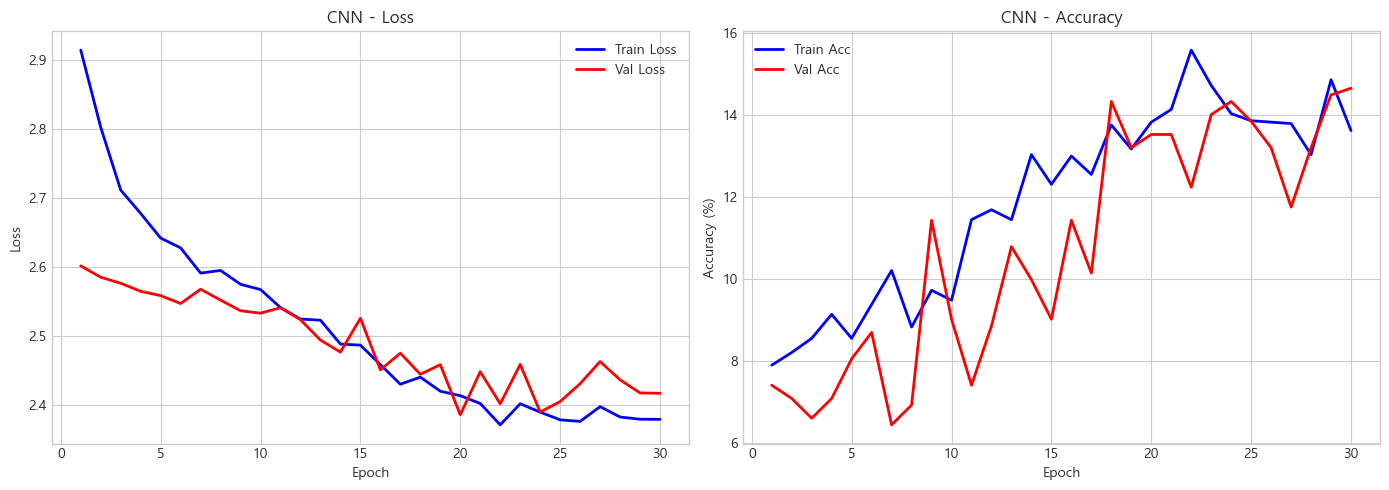

\n📊 CRNN 학습 결과


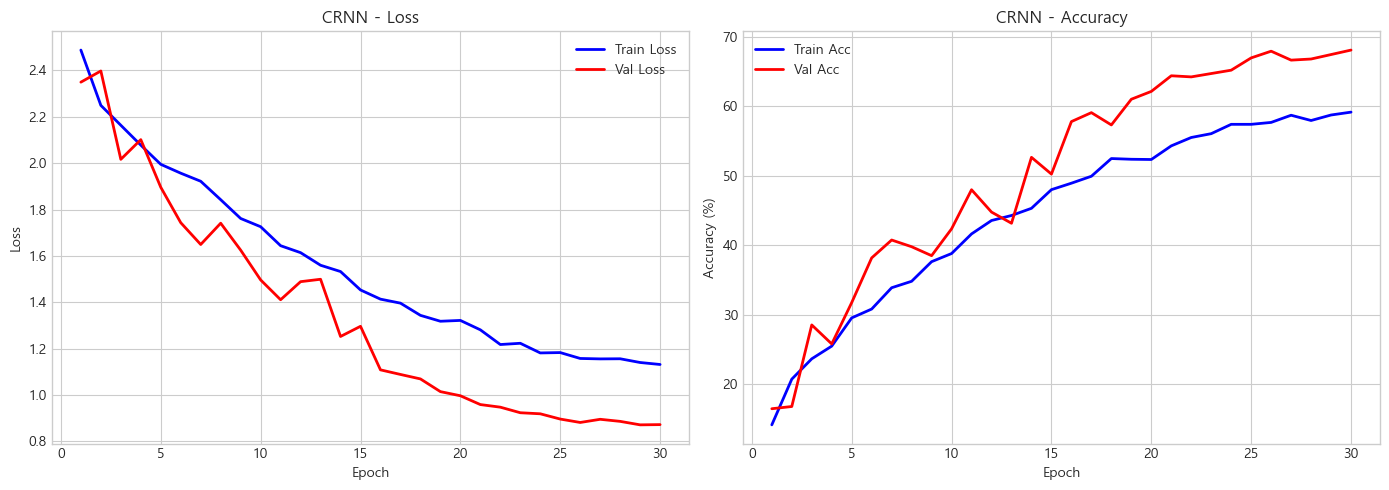

In [14]:
# ============================================================
# 학습 결과 시각화
# ============================================================

def plot_training_history(history, title):
    """학습 히스토리 시각화"""
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    epochs = range(1, len(history['train_loss']) + 1)
    
    # Loss
    axes[0].plot(epochs, history['train_loss'], 'b-', label='Train Loss', linewidth=2)
    axes[0].plot(epochs, history['val_loss'], 'r-', label='Val Loss', linewidth=2)
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].set_title(f'{title} - Loss')
    axes[0].legend()
    axes[0].grid(True)
    
    # Accuracy
    axes[1].plot(epochs, history['train_acc'], 'b-', label='Train Acc', linewidth=2)
    axes[1].plot(epochs, history['val_acc'], 'r-', label='Val Acc', linewidth=2)
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy (%)')
    axes[1].set_title(f'{title} - Accuracy')
    axes[1].legend()
    axes[1].grid(True)
    
    plt.tight_layout()
    plt.show()

# CNN 학습 결과
print("📊 CNN 학습 결과")
plot_training_history(cnn_history, 'CNN')

# CRNN 학습 결과
print("\\n📊 CRNN 학습 결과")
plot_training_history(crnn_history, 'CRNN')


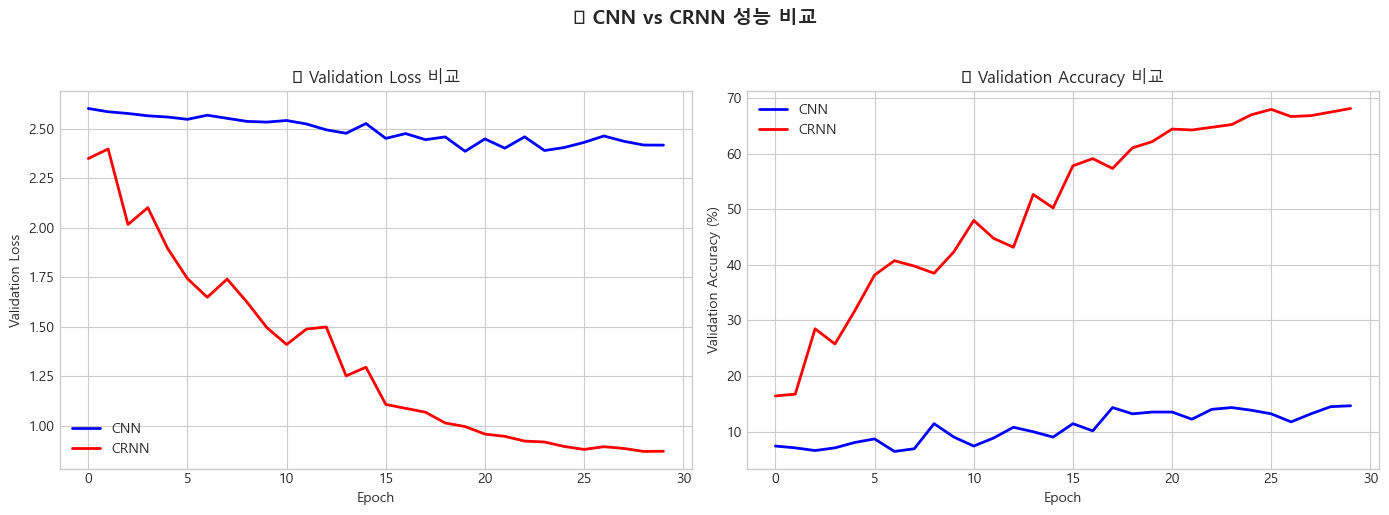

\n============================================================
📊 최종 성능 요약
\nCNN:
  • Best Val Loss: 2.3856
  • Best Val Acc: 14.65%
\nCRNN:
  • Best Val Loss: 0.8715
  • Best Val Acc: 68.12%


In [15]:
# ============================================================
# CNN vs CRNN 성능 비교
# ============================================================

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Validation Loss 비교
axes[0].plot(cnn_history['val_loss'], 'b-', label='CNN', linewidth=2)
axes[0].plot(crnn_history['val_loss'], 'r-', label='CRNN', linewidth=2)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Validation Loss')
axes[0].set_title('📊 Validation Loss 비교')
axes[0].legend()
axes[0].grid(True)

# Validation Accuracy 비교
axes[1].plot(cnn_history['val_acc'], 'b-', label='CNN', linewidth=2)
axes[1].plot(crnn_history['val_acc'], 'r-', label='CRNN', linewidth=2)
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Validation Accuracy (%)')
axes[1].set_title('📊 Validation Accuracy 비교')
axes[1].legend()
axes[1].grid(True)

plt.suptitle('🔍 CNN vs CRNN 성능 비교', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# 최종 성능 요약
print("\\n" + "=" * 60)
print("📊 최종 성능 요약")
print("=" * 60)
print(f"\\nCNN:")
print(f"  • Best Val Loss: {min(cnn_history['val_loss']):.4f}")
print(f"  • Best Val Acc: {max(cnn_history['val_acc']):.2f}%")
print(f"\\nCRNN:")
print(f"  • Best Val Loss: {min(crnn_history['val_loss']):.4f}")
print(f"  • Best Val Acc: {max(crnn_history['val_acc']):.2f}%")


## 6. 테스트 셋 평가


In [ ]:
# ============================================================
# 테스트 셋 평가 함수
# ============================================================

from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

def evaluate_model(model, test_loader, device, model_name="Model"):
    """모델 평가 및 혼동 행렬 출력"""
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for batch_x, batch_y in tqdm(test_loader, desc=f"Evaluating {model_name}"):
            batch_x = batch_x.to(device)
            outputs = model(batch_x)
            _, preds = outputs.max(1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(batch_y.numpy())
    
    # 정확도 계산
    accuracy = 100 * sum(p == l for p, l in zip(all_preds, all_labels)) / len(all_labels)
    
    print(f"\\n{'='*60}")
    print(f"📊 {model_name} 테스트 결과")
    print(f"{'='*60}")
    print(f"정확도: {accuracy:.2f}%")
    
    # 실제 존재하는 클래스만 사용
    unique_labels = sorted(set(all_labels) | set(all_preds))
    target_names = [idx_to_label.get(i, f"class_{i}") for i in unique_labels]
    
    # Classification Report
    print("\\n📋 Classification Report:")
    print(classification_report(all_labels, all_preds, labels=unique_labels, 
                                target_names=target_names, zero_division=0))
    
    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds, labels=unique_labels)
    
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=target_names, yticklabels=target_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'{model_name} - Confusion Matrix')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()
    
    return accuracy, all_preds, all_labels

print("✅ 평가 함수 정의 완료!")


✅ 평가 함수 정의 완료!


✅ CNN Best 모델 로드 완료 (Val Acc: 13.526570048309178%)
✅ CRNN Best 모델 로드 완료 (Val Acc: 67.4718196457327%)
\n🧪 CNN 테스트 평가...


Evaluating CNN: 100%|██████████| 39/39 [00:17<00:00,  2.26it/s]


\n============================================================
📊 CNN 테스트 결과
정확도: 13.50%
\n📋 Classification Report:
                                                                    precision    recall  f1-score   support

                                       braking state/normal_brakes       0.75      0.07      0.12        46
                                     braking state/worn_out_brakes       0.90      0.20      0.33        45
                        idle state/combined/no oil_serpentine belt       0.00      0.00      0.00        48
                idle state/combined/power steering combined_no oil       0.06      0.02      0.03        48
idle state/combined/power steering combined_no oil_serpentine belt       0.11      0.04      0.06        48
       idle state/combined/power steering combined_serpentine belt       0.00      0.00      0.00        53
                                                idle state/low_oil       0.00      0.00      0.00        48
                    

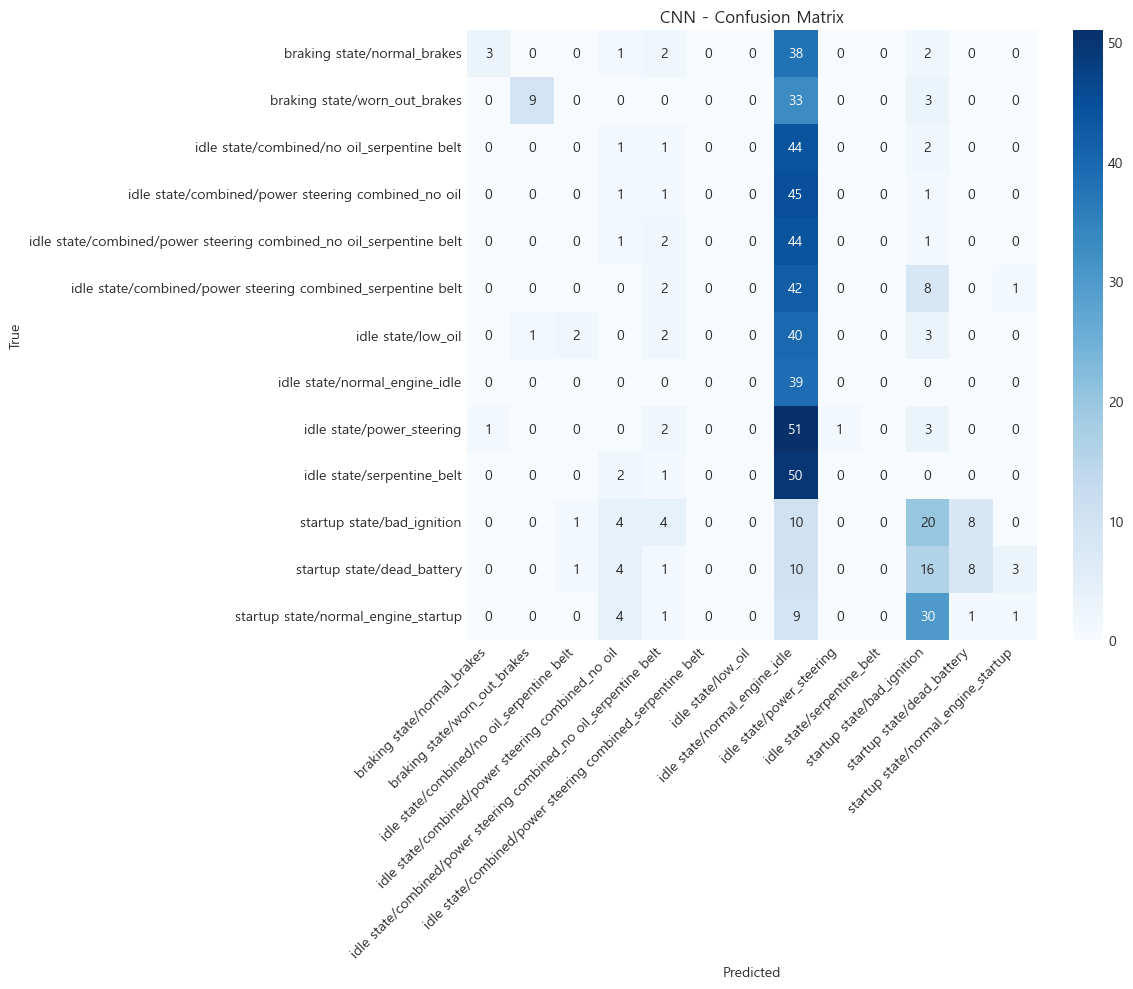

\n🧪 CRNN 테스트 평가...


Evaluating CRNN: 100%|██████████| 39/39 [00:28<00:00,  1.38it/s]


\n============================================================
📊 CRNN 테스트 결과
정확도: 63.50%
\n📋 Classification Report:
                                                                    precision    recall  f1-score   support

                                       braking state/normal_brakes       0.83      0.87      0.85        46
                                     braking state/worn_out_brakes       1.00      0.71      0.83        45
                        idle state/combined/no oil_serpentine belt       0.48      0.44      0.46        48
                idle state/combined/power steering combined_no oil       0.31      0.23      0.26        48
idle state/combined/power steering combined_no oil_serpentine belt       0.35      0.27      0.31        48
       idle state/combined/power steering combined_serpentine belt       0.39      0.25      0.30        53
                                                idle state/low_oil       0.48      0.62      0.54        48
                   

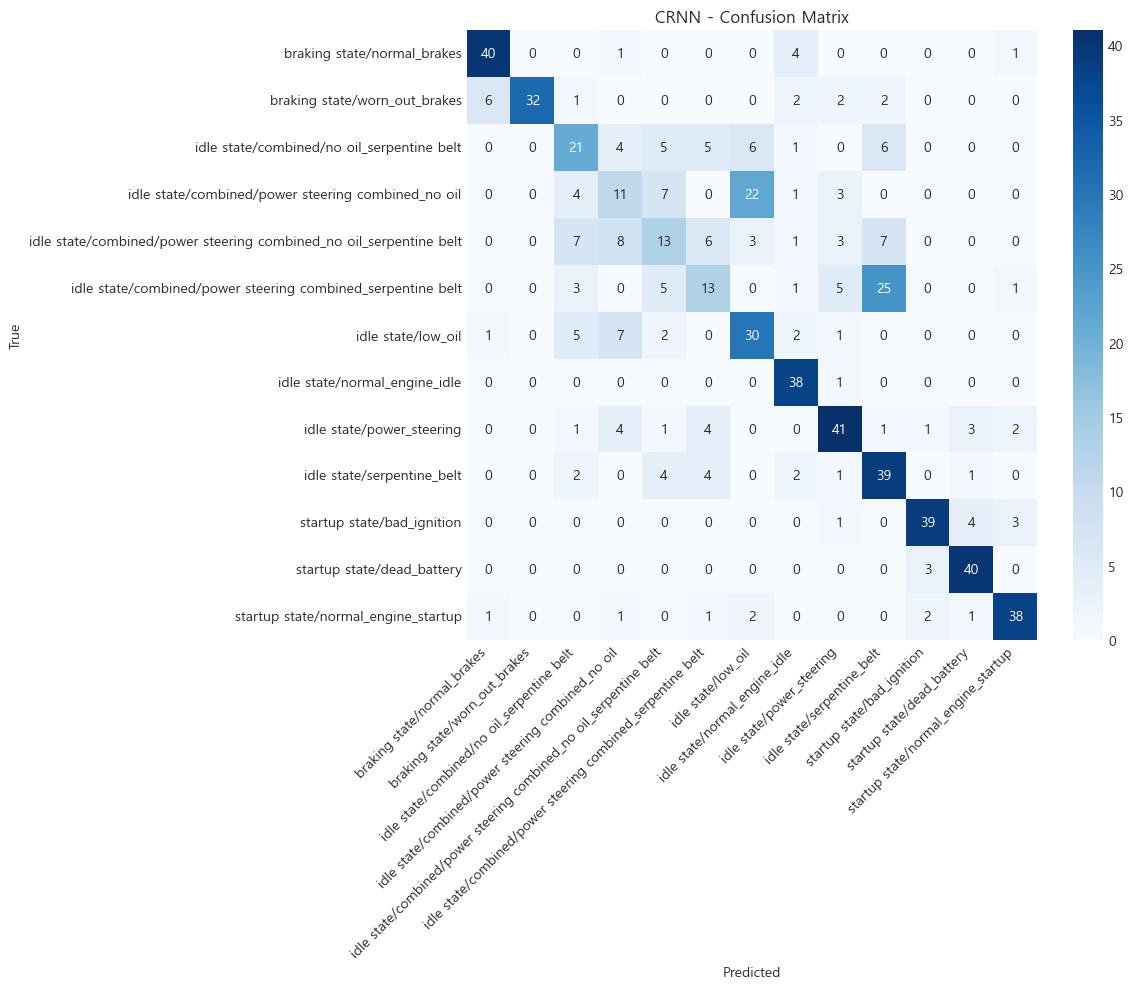

In [19]:
# ============================================================
# Best 모델 로드 및 테스트 평가
# ============================================================

# CNN Best 모델 로드
cnn_best_path = checkpoint_dir / 'cnn_sound_classifier_best_model.pt'
if cnn_best_path.exists():
    cnn_checkpoint = torch.load(cnn_best_path, map_location=device)
    cnn_model.load_state_dict(cnn_checkpoint['model_state_dict'])
    print(f"✅ CNN Best 모델 로드 완료 (Val Acc: {cnn_checkpoint.get('val_acc', 'N/A')}%)")

# CRNN Best 모델 로드
crnn_best_path = checkpoint_dir / 'crnn_sound_classifier_best_model.pt'
if crnn_best_path.exists():
    crnn_checkpoint = torch.load(crnn_best_path, map_location=device)
    crnn_model.load_state_dict(crnn_checkpoint['model_state_dict'])
    print(f"✅ CRNN Best 모델 로드 완료 (Val Acc: {crnn_checkpoint.get('val_acc', 'N/A')}%)")

# 테스트 평가
print("\\n🧪 CNN 테스트 평가...")
cnn_test_acc, _, _ = evaluate_model(cnn_model, test_loader, device, "CNN")

print("\\n🧪 CRNN 테스트 평가...")
crnn_test_acc, _, _ = evaluate_model(crnn_model, test_loader, device, "CRNN")


## 7. 학습 요약


In [20]:
# ============================================================
# 학습 완료 요약
# ============================================================

print("=" * 60)
print("🎉 모델 학습 완료!")
print("=" * 60)

print(f"""
📊 학습 요약:
  • 총 샘플: {len(all_files)}개 (원본 + 증강)
  • 총 클래스: {NUM_CLASSES}개
  • Epochs: {EPOCHS}
  
🔧 적용된 기법:
  • 데이터 증강 (Time Stretch, Pitch Shift, Noise 등)
  • SpecAugment (학습 중 실시간 적용)
  • 클래스 가중치 (불균형 데이터 보정)
  • Mixed Precision Training (GPU)
  • Early Stopping
  • Cosine Annealing LR

📈 테스트 성능:
  • CNN: {cnn_test_acc:.2f}%
  • CRNN: {crnn_test_acc:.2f}%

📁 저장된 모델:
  • checkpoints/cnn_sound_classifier_best_model.pt
  • checkpoints/crnn_sound_classifier_best_model.pt

💡 다음 단계:
  1. 모델 앙상블 (CNN + CRNN)
  2. Attention 시각화 (CRNN)
  3. 실시간 추론 API 구현
""")
print("=" * 60)


🎉 모델 학습 완료!

📊 학습 요약:
  • 총 샘플: 4143개 (원본 + 증강)
  • 총 클래스: 14개
  • Epochs: 30

🔧 적용된 기법:
  • 데이터 증강 (Time Stretch, Pitch Shift, Noise 등)
  • SpecAugment (학습 중 실시간 적용)
  • 클래스 가중치 (불균형 데이터 보정)
  • Mixed Precision Training (GPU)
  • Early Stopping
  • Cosine Annealing LR

📈 테스트 성능:
  • CNN: 13.50%
  • CRNN: 63.50%

📁 저장된 모델:
  • checkpoints/cnn_sound_classifier_best_model.pt
  • checkpoints/crnn_sound_classifier_best_model.pt

💡 다음 단계:
  1. 모델 앙상블 (CNN + CRNN)
  2. Attention 시각화 (CRNN)
  3. 실시간 추론 API 구현



## 8. CRNN Attention 시각화

CRNN 모델이 어떤 시간 구간에 집중하는지 Attention weights를 시각화합니다.


In [21]:
# ============================================================
# CRNN Attention 시각화 함수
# ============================================================

def visualize_attention(model, sample_input, sample_path, true_label, idx_to_label, sr=22050):
    """
    CRNN 모델의 Attention weights 시각화
    
    Parameters:
    -----------
    model : SoundClassifierCRNN - CRNN 모델
    sample_input : torch.Tensor - 입력 텐서 (1, 1, n_mels, time_frames)
    sample_path : str - 원본 오디오 파일 경로
    true_label : int - 실제 레이블
    idx_to_label : dict - 인덱스 → 레이블 매핑
    sr : int - 샘플링 레이트
    """
    model.eval()
    
    with torch.no_grad():
        # Attention weights와 함께 예측
        output, attention_weights = model.forward_with_attention(sample_input.to(device))
        pred_class = output.argmax(dim=1).item()
        confidence = torch.softmax(output, dim=1).max().item() * 100
    
    # Attention weights를 numpy로 변환
    attn = attention_weights.cpu().numpy().squeeze()  # (time_frames,)
    
    # 원본 오디오 로드
    y, _ = librosa.load(str(sample_path), sr=sr)
    
    # Mel Spectrogram 계산
    mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
    
    # 시각화
    fig, axes = plt.subplots(3, 1, figsize=(14, 10), gridspec_kw={'height_ratios': [1, 2, 1]})
    
    # 1. Waveform
    time_audio = np.linspace(0, len(y)/sr, len(y))
    axes[0].plot(time_audio, y, color='blue', alpha=0.7)
    axes[0].set_ylabel('Amplitude')
    axes[0].set_title(f'🔊 Waveform', fontsize=12)
    axes[0].set_xlim(0, len(y)/sr)
    
    # 2. Mel Spectrogram + Attention Overlay
    time_spec = np.linspace(0, len(y)/sr, mel_spec_db.shape[1])
    img = librosa.display.specshow(mel_spec_db, sr=sr, hop_length=512, 
                                    x_axis='time', y_axis='mel', ax=axes[1], cmap='magma')
    axes[1].set_title(f'🎵 Mel Spectrogram', fontsize=12)
    
    # 3. Attention Weights
    time_attn = np.linspace(0, len(y)/sr, len(attn))
    axes[2].fill_between(time_attn, attn, alpha=0.7, color='red')
    axes[2].plot(time_attn, attn, color='darkred', linewidth=2)
    axes[2].set_xlabel('Time (sec)')
    axes[2].set_ylabel('Attention')
    axes[2].set_title(f'🎯 Attention Weights (모델이 집중하는 구간)', fontsize=12)
    axes[2].set_xlim(0, len(y)/sr)
    axes[2].set_ylim(0, attn.max() * 1.1)
    
    # 최대 attention 위치 표시
    max_attn_idx = np.argmax(attn)
    max_attn_time = time_attn[max_attn_idx]
    axes[2].axvline(x=max_attn_time, color='green', linestyle='--', linewidth=2, label=f'Max @ {max_attn_time:.2f}s')
    axes[2].legend()
    
    # 전체 제목
    true_name = idx_to_label.get(true_label, f"class_{true_label}")
    pred_name = idx_to_label.get(pred_class, f"class_{pred_class}")
    
    if true_label == pred_class:
        result = "✅ 정답!"
        color = "green"
    else:
        result = "❌ 오답"
        color = "red"
    
    fig.suptitle(f'{result}  실제: {true_name}  |  예측: {pred_name} ({confidence:.1f}%)', 
                 fontsize=14, fontweight='bold', color=color, y=1.02)
    
    plt.tight_layout()
    plt.show()
    
    return attn, pred_class, confidence

print("✅ Attention 시각화 함수 정의 완료!")


✅ Attention 시각화 함수 정의 완료!


🎯 CRNN Attention 시각화
테스트 셋에서 6개 샘플 시각화\n
\n--- 샘플 1/6 ---


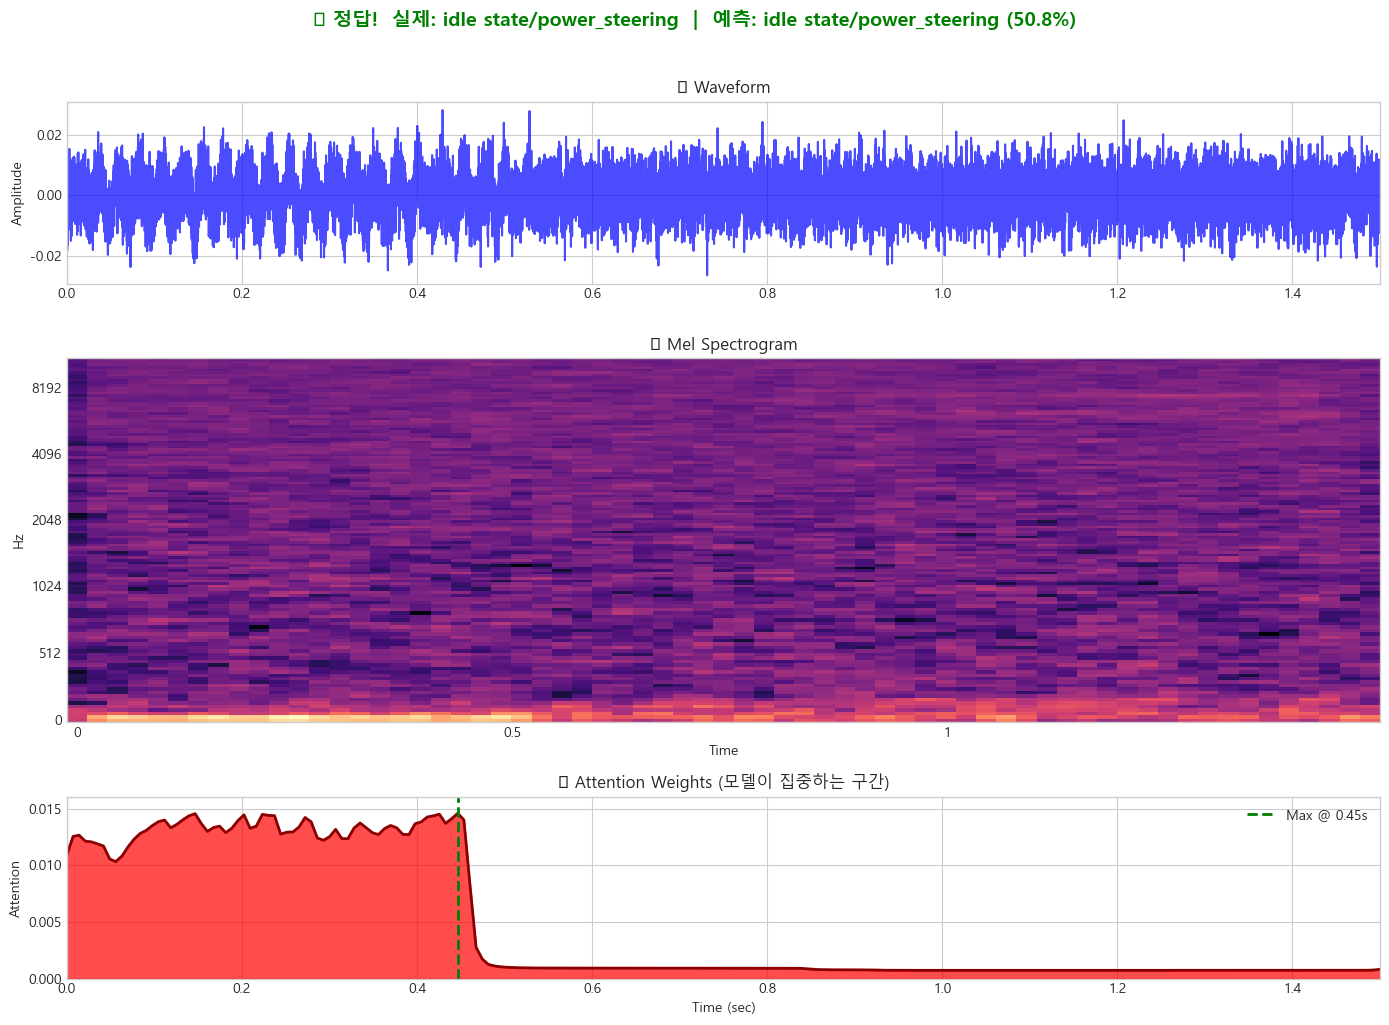

\n--- 샘플 2/6 ---


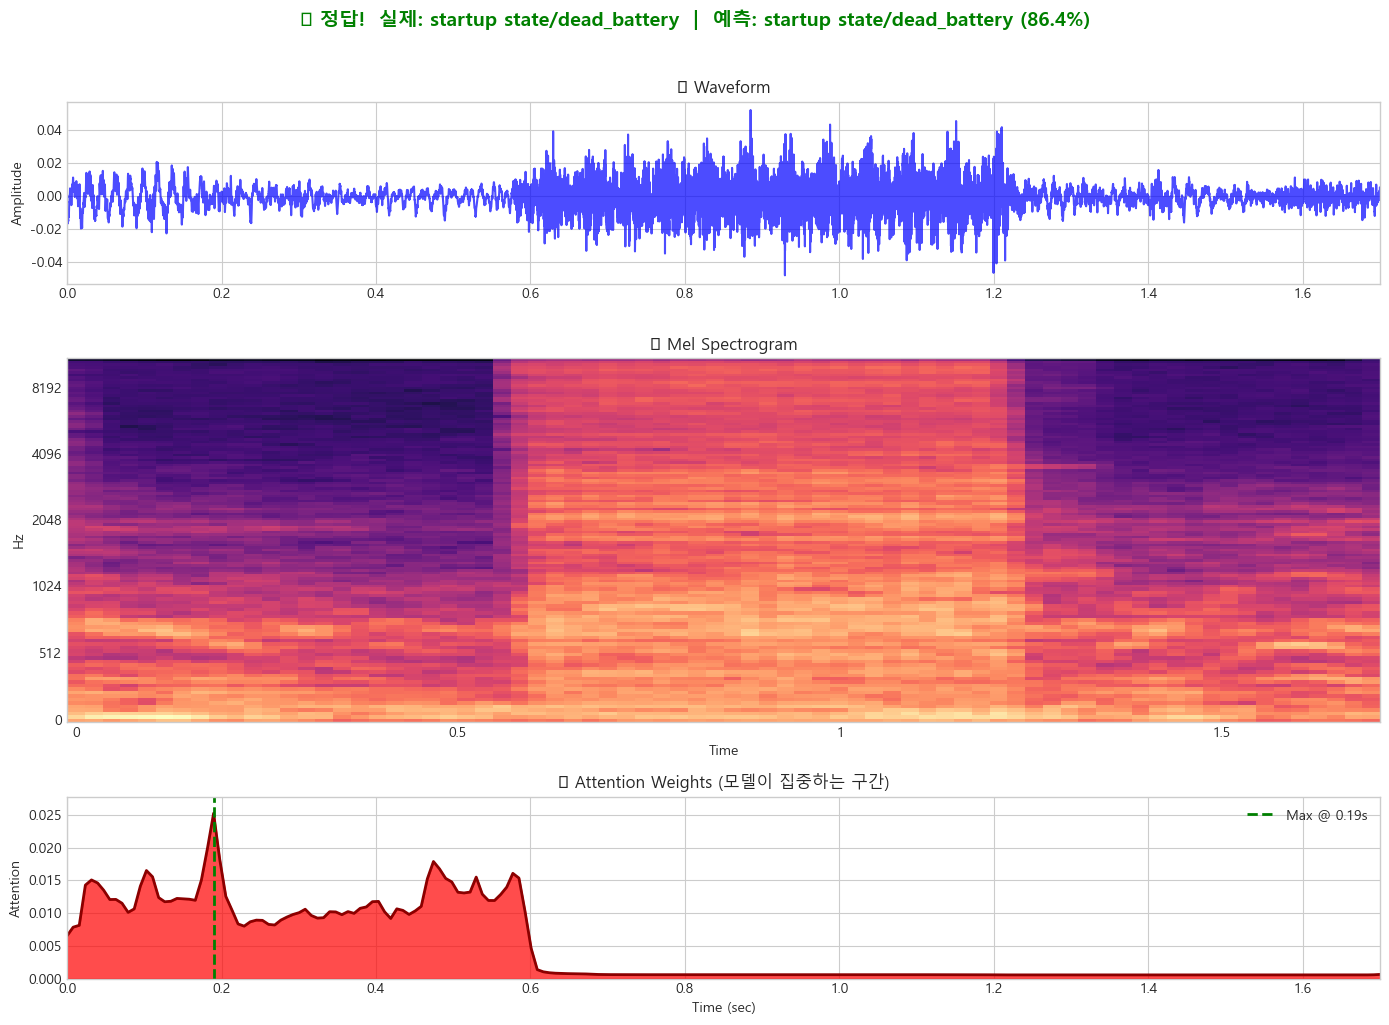

\n--- 샘플 3/6 ---


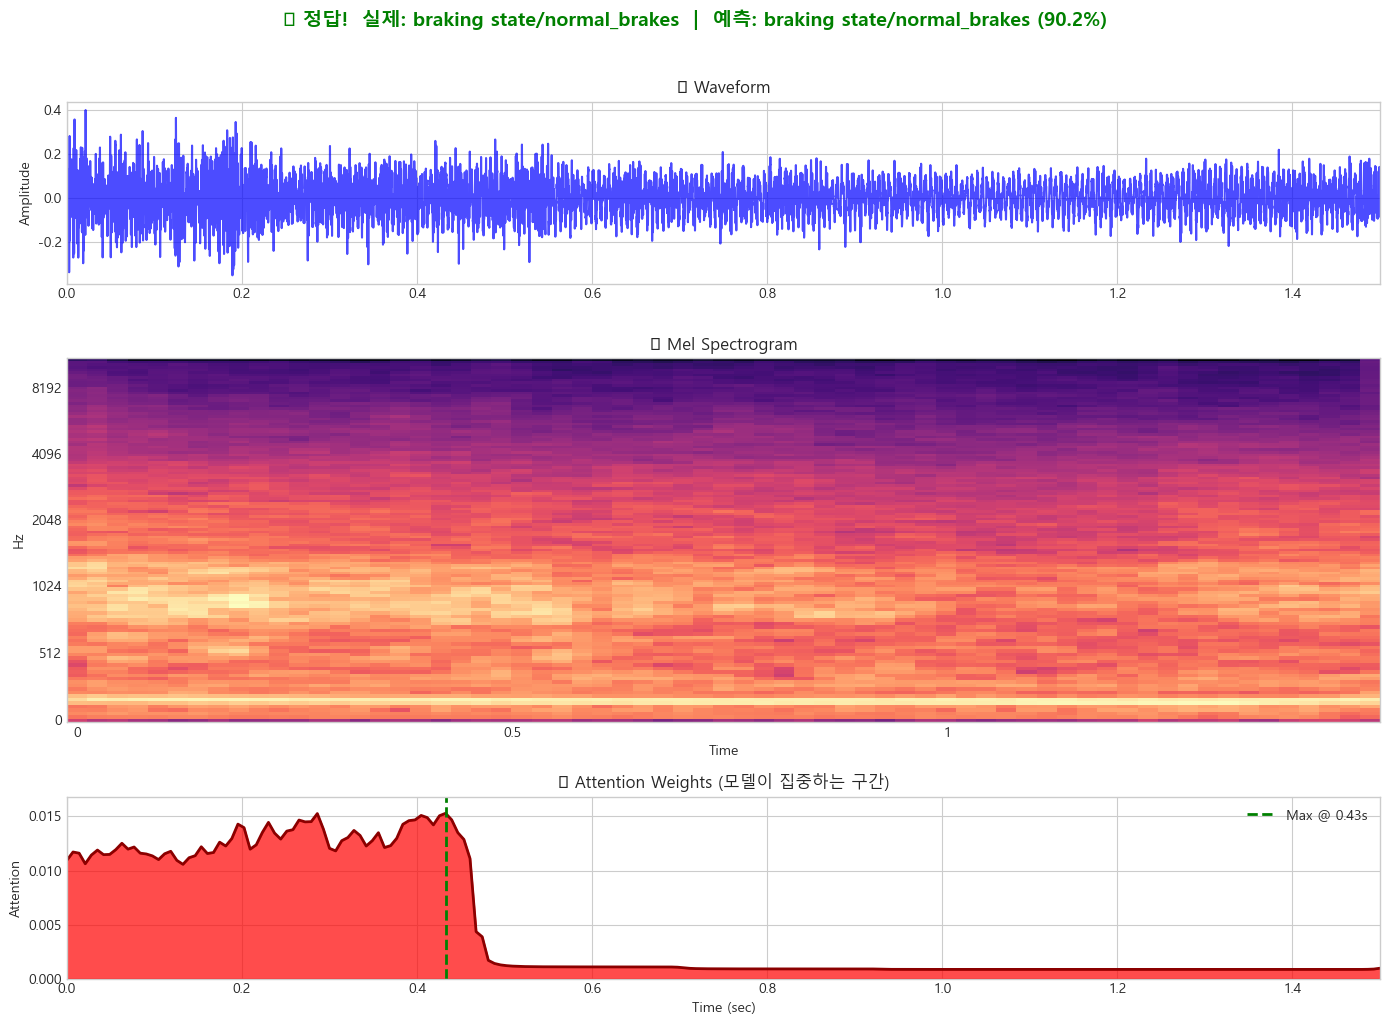

\n--- 샘플 4/6 ---


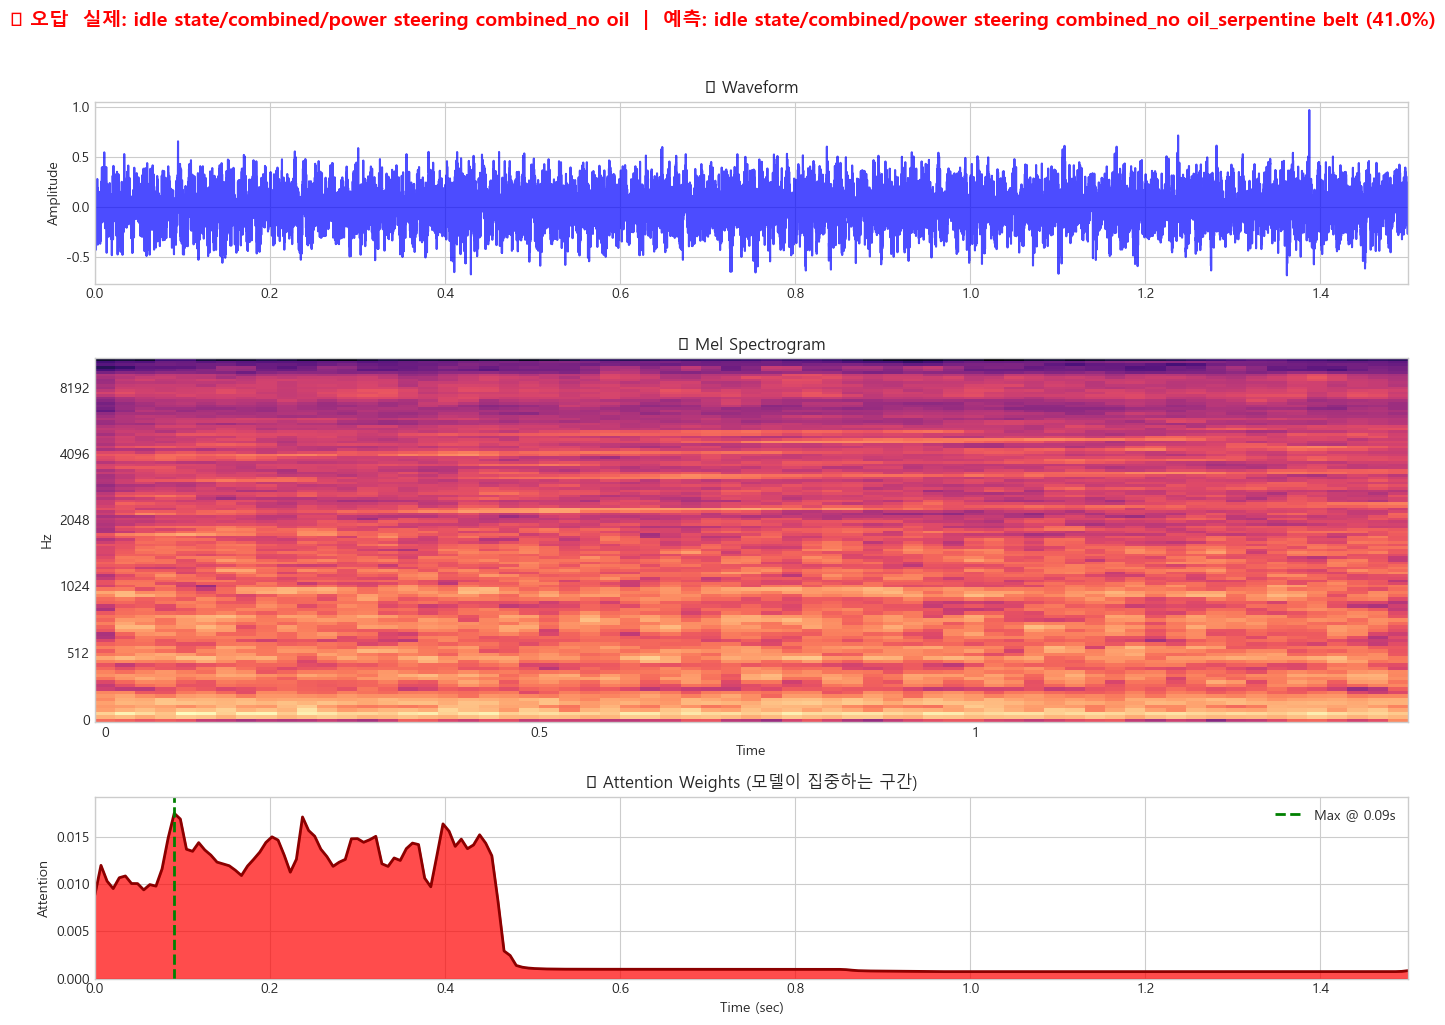

\n--- 샘플 5/6 ---


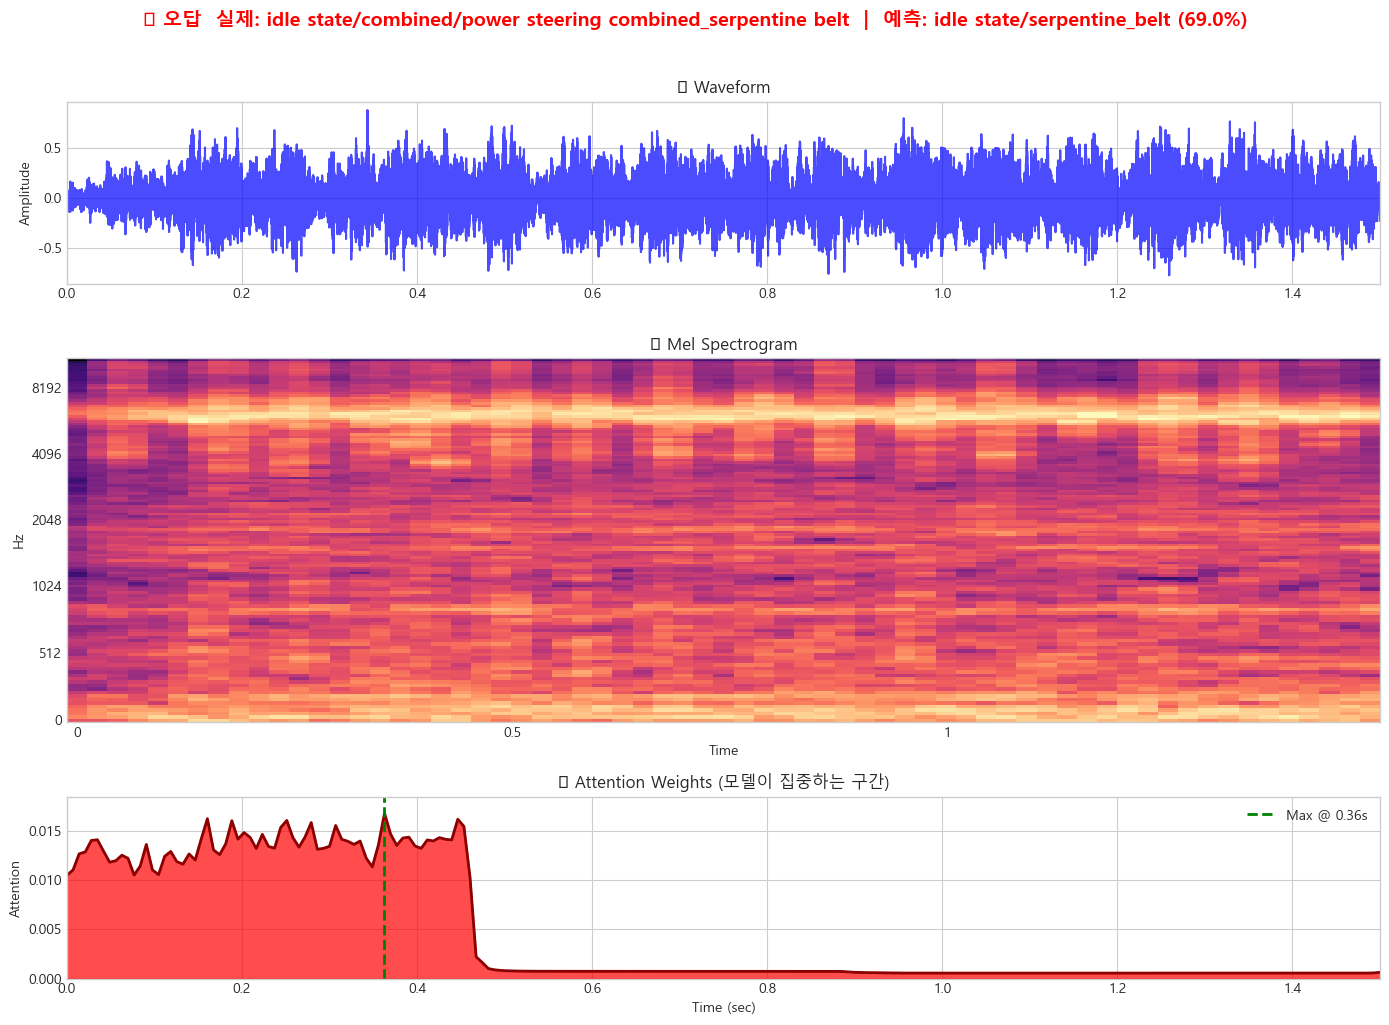

\n--- 샘플 6/6 ---


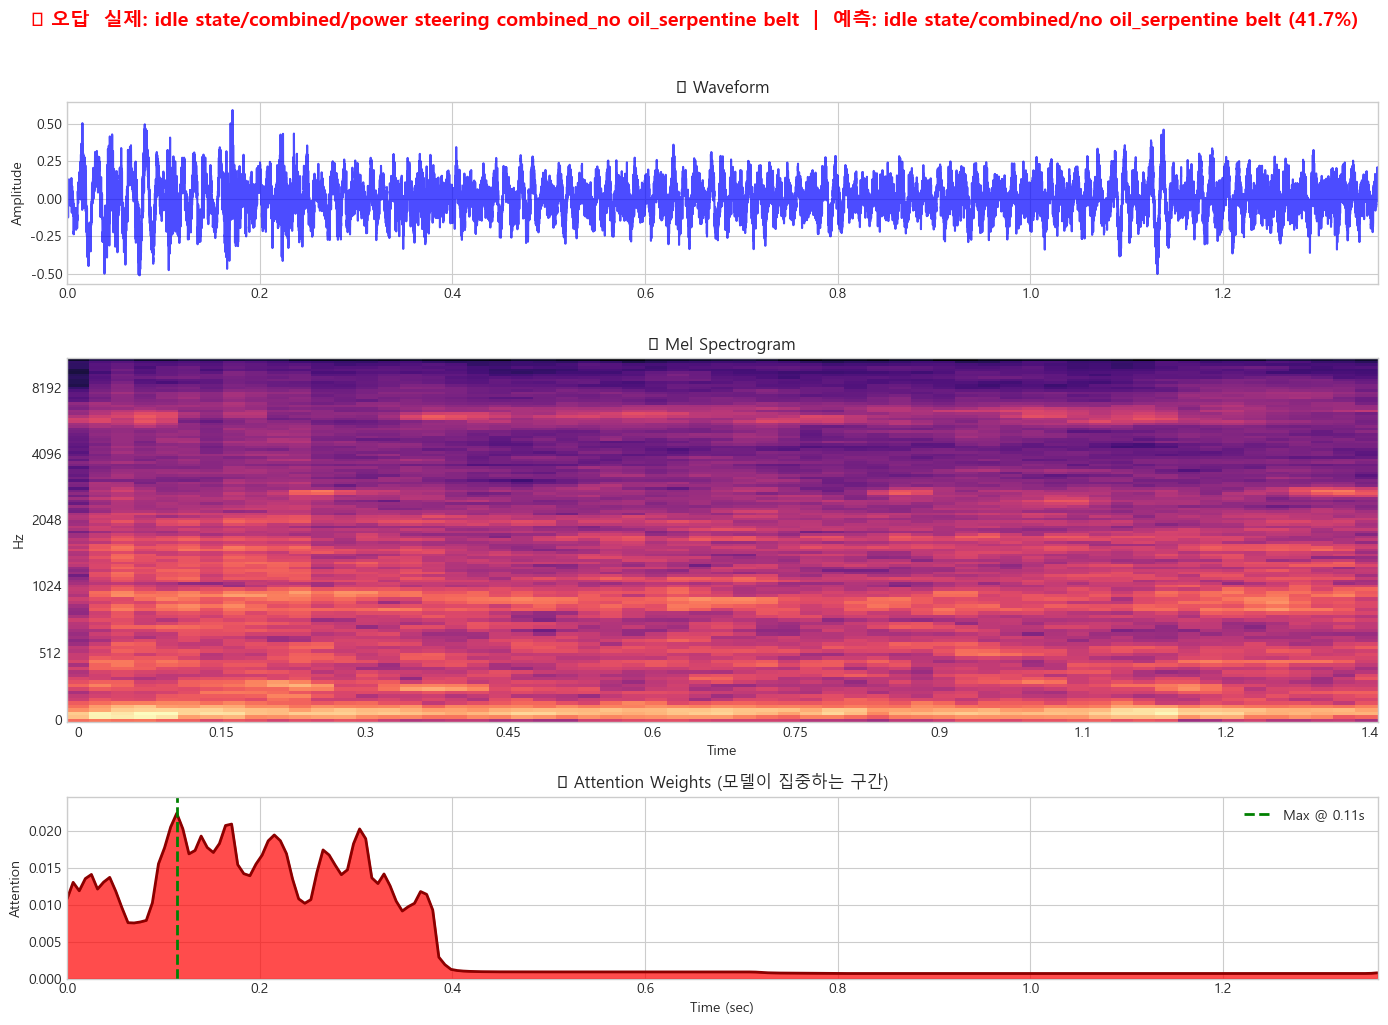

In [22]:
# ============================================================
# 테스트 샘플에서 Attention 시각화
# ============================================================

import random

# 테스트 셋에서 랜덤 샘플 선택
num_samples = 6
sample_indices = random.sample(range(len(X_test)), min(num_samples, len(X_test)))

print("🎯 CRNN Attention 시각화")
print("=" * 60)
print(f"테스트 셋에서 {num_samples}개 샘플 시각화\\n")

for i, idx in enumerate(sample_indices):
    sample_path = X_test[idx]
    true_label = y_test[idx]
    
    # 피처 추출
    features = feature_extractor.extract_for_cnn(str(sample_path))
    sample_input = torch.FloatTensor(features).unsqueeze(0)  # (1, 1, n_mels, time_frames)
    
    print(f"\\n--- 샘플 {i+1}/{num_samples} ---")
    attn, pred, conf = visualize_attention(
        crnn_model, sample_input, sample_path, true_label, idx_to_label
    )


🔍 정상 vs 비정상 Attention 패턴 분석


Attention 분석: 100%|██████████| 100/100 [00:05<00:00, 16.91it/s]


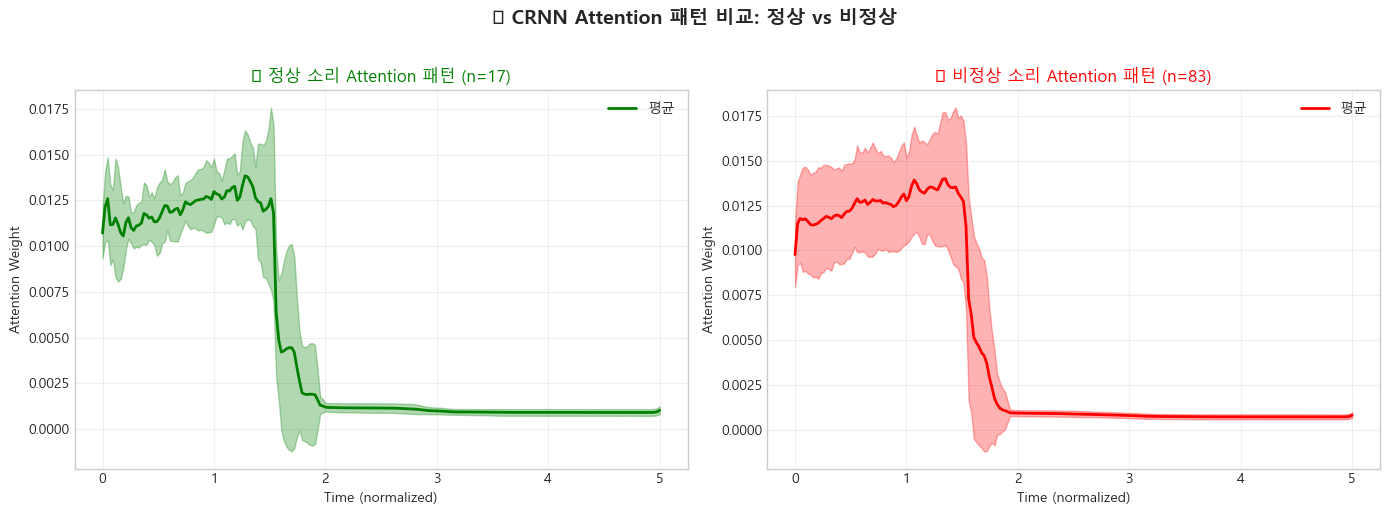

\n💡 해석:
  • 정상 소리: 전체적으로 고르게 attention 분포
  • 비정상 소리: 특정 시간대에 attention이 집중될 수 있음 (이상 신호 구간)


In [23]:
# ============================================================
# Attention 분포 분석: 정상 vs 비정상
# ============================================================

def analyze_attention_patterns(model, file_paths, labels, idx_to_label, feature_extractor, device, num_samples=50):
    """정상/비정상 클래스의 Attention 패턴 분석"""
    
    normal_attentions = []
    abnormal_attentions = []
    
    # 샘플 선택
    indices = random.sample(range(len(file_paths)), min(num_samples, len(file_paths)))
    
    model.eval()
    for idx in tqdm(indices, desc="Attention 분석"):
        path = file_paths[idx]
        label = labels[idx]
        label_name = idx_to_label.get(label, "")
        
        # 피처 추출
        features = feature_extractor.extract_for_cnn(str(path))
        sample_input = torch.FloatTensor(features).unsqueeze(0).to(device)
        
        with torch.no_grad():
            _, attn_weights = model.forward_with_attention(sample_input)
            attn = attn_weights.cpu().numpy().squeeze()
        
        # 정상/비정상 분류
        if 'normal' in label_name.lower() or '정상' in label_name:
            normal_attentions.append(attn)
        else:
            abnormal_attentions.append(attn)
    
    return normal_attentions, abnormal_attentions

# Attention 패턴 분석
print("🔍 정상 vs 비정상 Attention 패턴 분석")
normal_attn, abnormal_attn = analyze_attention_patterns(
    crnn_model, X_test, y_test, idx_to_label, feature_extractor, device, num_samples=100
)

# 평균 Attention 시각화
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

if normal_attn:
    # 길이 맞추기 (가장 짧은 것 기준)
    min_len = min(len(a) for a in normal_attn)
    normal_attn_trimmed = [a[:min_len] for a in normal_attn]
    normal_mean = np.mean(normal_attn_trimmed, axis=0)
    normal_std = np.std(normal_attn_trimmed, axis=0)
    
    time_axis = np.linspace(0, 5, len(normal_mean))
    axes[0].fill_between(time_axis, normal_mean - normal_std, normal_mean + normal_std, alpha=0.3, color='green')
    axes[0].plot(time_axis, normal_mean, 'g-', linewidth=2, label='평균')
    axes[0].set_xlabel('Time (normalized)')
    axes[0].set_ylabel('Attention Weight')
    axes[0].set_title(f'✅ 정상 소리 Attention 패턴 (n={len(normal_attn)})', fontsize=12, color='green')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

if abnormal_attn:
    min_len = min(len(a) for a in abnormal_attn)
    abnormal_attn_trimmed = [a[:min_len] for a in abnormal_attn]
    abnormal_mean = np.mean(abnormal_attn_trimmed, axis=0)
    abnormal_std = np.std(abnormal_attn_trimmed, axis=0)
    
    time_axis = np.linspace(0, 5, len(abnormal_mean))
    axes[1].fill_between(time_axis, abnormal_mean - abnormal_std, abnormal_mean + abnormal_std, alpha=0.3, color='red')
    axes[1].plot(time_axis, abnormal_mean, 'r-', linewidth=2, label='평균')
    axes[1].set_xlabel('Time (normalized)')
    axes[1].set_ylabel('Attention Weight')
    axes[1].set_title(f'❌ 비정상 소리 Attention 패턴 (n={len(abnormal_attn)})', fontsize=12, color='red')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)

plt.suptitle('🎯 CRNN Attention 패턴 비교: 정상 vs 비정상', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print("\\n💡 해석:")
print("  • 정상 소리: 전체적으로 고르게 attention 분포")
print("  • 비정상 소리: 특정 시간대에 attention이 집중될 수 있음 (이상 신호 구간)")
